## Counting Spectra and Redshifts in DR1

Count the number of successful redshifts obtained in DR1 for the DR1 paper, in total and per tracer class.

Based on a script originally written by Anthony Kremin (LBNL, March 2023).

John Moustakas  
Siena College  
December 2023

### Setup

#### Import modules and set latex table formatting.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import fitsio

from astropy.io import fits
from astropy.table import Table, vstack
from astropy.io import ascii

rand = np.random.default_rng(seed=1)

# latex_dict = {'tabletype': 'deluxetable*', 'tablealign':'htb'}
save_figures = False

#### Import survey-specific targeting information from [desitarget](https://github.com/desihub/desitarget) and define the surveys and tracers.

In [2]:
from desitarget.cmx.cmx_targetmask import cmx_mask as cmxmask
from desitarget.sv1.sv1_targetmask import desi_mask as sv1mask
from desitarget.sv2.sv2_targetmask import desi_mask as sv2mask
from desitarget.sv3.sv3_targetmask import desi_mask as sv3mask
from desitarget.targetmask import desi_mask

tracers = ['BGS', 'ELG', 'LRG', 'QSO', 'STAR', 'SCND']

allsurveys = ['cmx', 'sv1', 'sv2', 'sv3', 'special', 'main']
groupsurveys = ['sv', 'special', 'main'] # group SV together for the object counts

desi_masks = {}
desi_masks['main'] = desi_mask
desi_masks['special'] = desi_mask
desi_masks['cmx'] = cmxmask
desi_masks['sv1'] = sv1mask
desi_masks['sv2'] = sv2mask
desi_masks['sv3'] = sv3mask

mask_colnames = {}
mask_colnames['main'] = 'DESI_TARGET'
mask_colnames['special'] = 'DESI_TARGET'
mask_colnames['cmx'] = 'CMX_TARGET'
mask_colnames['sv1'] = 'SV1_DESI_TARGET'
mask_colnames['sv2'] = 'SV2_DESI_TARGET'
mask_colnames['sv3'] = 'SV3_DESI_TARGET'

#### Define some support routines needed below.

In [3]:
def get_targeting_bits(targetid):
    targ = []
    for name in desi_mask.names():
        if desi_mask.mask(name) & targetid != 0:
            targ.append(name)
    return ' '.join(targ)

def latex_N_subscript(subscript):
    return r'$\mathrm{N}_{\mathrm{'+subscript+r'}}$'

def format_number(number):
    return f"{number:,}"

def populate_row(survey, subset_table, tracers):
    row = {'Survey': survey}
    for tracer in tracers:
        if tracer == 'Total':
            colname = 'GOODTYPE'
        else:
            colname = f"IS{tracer}"
        num = int(np.sum(subset_table[colname]))
        row[latex_N_subscript(tracer)] = format_number(num)
    return row

In [4]:
def read_zcat(specprod='iron'):
    """Read the redshift catalog for a given specprod.
    
    """
    readcols = np.array(['TARGETID', 'SURVEY', 'PROGRAM', 'OBJTYPE', 
                        'SPECTYPE', 'Z',  'ZWARN',  'DELTACHI2',
                        'COADD_FIBERSTATUS',  'ZCAT_NSPEC', 'ZCAT_PRIMARY',
                        'CMX_TARGET', 'DESI_TARGET', 'SV1_DESI_TARGET', 'SV2_DESI_TARGET', 'SV3_DESI_TARGET'])
    
    zcatdir = os.path.join(os.getenv('DESI_ROOT'), 'spectro', 'redux', specprod, 'zcatalog')
    
    if specprod != 'fuji': # use patched guadalupe & iron catalogs
        zcatdir = os.path.join(zcatdir, 'v1')
    zcatfile = os.path.join(zcatdir, f'zall-pix-{specprod}.fits')
    
    allcols = np.array(fitsio.FITS(zcatfile)['ZCATALOG'].get_colnames())
    readcols = allcols[np.isin(allcols, readcols)]
    
    zcat = Table(fitsio.read(zcatfile, columns=readcols))
    print(f'Read {len(zcat):,d} rows from {zcatfile}')
        
    return zcat

In [5]:
def identify_tracers(input_zcat):
    """For each survey and tracer, use the appropriate bitmasks to 
    identify targeted objects that turned out to be the correct type.
    
    """
    # Initialize columns to keep track of tracers. Set to -1 so we can ensure we fill all rows
    zcat = input_zcat.copy()    
    for tracer in tracers:
        zcat.add_column(Table.Column(data=-1*np.ones(len(zcat)), dtype=int, name=f"IS{tracer}"))

    for survey in sorted(set(zcat['SURVEY'])):
        #print(f'Identifying targets for survey: {survey}')
        desi_mask = desi_masks[survey]
        colname = mask_colnames[survey]
        bits = {}
        if survey == 'cmx':
            bgs = desi_mask.mask('MINI_SV_BGS_BRIGHT|SV0_BGS')
            elg = desi_mask.mask('MINI_SV_ELG|SV0_ELG')
            lrg = desi_mask.mask('MINI_SV_LRG|SV0_LRG')
            qso = desi_mask.mask('MINI_SV_QSO|SV0_QSO|SV0_QSO_Z5')
            starbitnames = 'STD_GAIA|SV0_STD_FAINT|SV0_STD_BRIGHT|STD_TEST|STD_CALSPEC|STD_DITHER|' \
                         + 'SV0_MWS_CLUSTER|SV0_MWS_CLUSTER_VERYBRIGHT|SV0_MWS|SV0_WD|BACKUP_BRIGHT|' \
                         + 'BACKUP_FAINT|M31_STD_BRIGHT|M31_H2PN|M31_GC|M31_QSO|M31_VAR|M31_BSPL|M31_M31cen|' \
                         + 'M31_M31out|ORI_STD_BRIGHT|ORI_QSO|ORI_ORI|ORI_HA|M33_STD_BRIGHT|M33_H2PN|M33_GC|' \
                         + 'M33_QSO|M33_M33cen|M33_M33out|SV0_MWS_FAINT|STD_DITHER_GAIA|STD_FAINT|STD_BRIGHT'
            star = desi_mask.mask(starbitnames)
            sec = 2**70 # secondaries don't exist in cmx, so set it to above the 63rd bit
        else:
            bgs = desi_mask.mask('BGS_ANY')
            elg = desi_mask.mask('ELG')
            lrg = desi_mask.mask('LRG')
            qso = desi_mask.mask('QSO') 
            sec = desi_mask.mask('SCND_ANY')
            star = desi_mask.mask('MWS_ANY|STD_FAINT|STD_WD|STD_BRIGHT')
    
        survey_selection = zcat['SURVEY'] == survey
        survey_subset = zcat[survey_selection]
    
        # Check if a {GALAXY,QSO,STAR} target was classified by Redrock as a galaxy, qso, or star.
        GALTYPE = survey_subset['SPECTYPE'] == 'GALAXY'
        STARTYPE = survey_subset['SPECTYPE'] == 'STAR'
        QSOTYPE = survey_subset['SPECTYPE'] == 'QSO'
    
        # BGS
        PASSES_BIT_SEL = (survey_subset[colname] & bgs) > 0
        zcat['ISBGS'][survey_selection] = PASSES_BIT_SEL & GALTYPE
    
        # ELG
        PASSES_BIT_SEL = (survey_subset[colname] & elg) > 0
        zcat['ISELG'][survey_selection] = PASSES_BIT_SEL & GALTYPE
    
        # LRG
        PASSES_BIT_SEL = (survey_subset[colname] & lrg) > 0
        zcat['ISLRG'][survey_selection] = PASSES_BIT_SEL & GALTYPE
    
        # QSO
        PASSES_BIT_SEL = (survey_subset[colname] & qso) > 0
        zcat['ISQSO'][survey_selection] = PASSES_BIT_SEL & QSOTYPE
    
        # STAR
        PASSES_BIT_SEL = (survey_subset[colname] & star) > 0
        zcat['ISSTAR'][survey_selection] = PASSES_BIT_SEL & STARTYPE
    
        # Secondaries
        PASSES_BIT_SEL = (survey_subset[colname] & sec) > 0
        zcat['ISSCND'][survey_selection] = PASSES_BIT_SEL
    
        #zcat.remove_column(colname)
            
    # For each tracer, make sure none of the column entries are still the default (-1) then set column to be a boolean.
    for tracer in tracers:
        col = f"IS{tracer}"
        if np.any(zcat[col] < 0):
            raise ValueError("Found {np.sum(zcat[col]):,d} uncategorized tracers {tracer}")
        zcat[col] = Table.Column(data=zcat[col], name=col, dtype=bool)
        
    # Flag extragalactic targets.
    extragal = np.zeros(len(zcat), dtype=bool)
    for tracer in ['BGS', 'ELG', 'LRG', 'QSO']:
        if tracer in tracers:
            extragal |= zcat[f"IS{tracer}"].data
    zcat.add_column(Table.Column(data=extragal, name='ISEXG'))
        
    # Flag objects where targeting and Redrock agree on the category/class.
    anytracer = np.zeros(len(zcat), dtype=bool)
    for tracer in tracers:
        anytracer |= np.array(zcat[f"IS{tracer}"].data).astype(bool)
    zcat.add_column(Table.Column(data=anytracer, name='GOODTYPE'))
        
    return zcat

In [25]:
def parse_zcat(input_zcat, specprod='iron', remove_columns=False, verbose=True):
    """Parse a given redshift catalog.
    
    If groupsv=True then get the combined statistics for the cmx+sv? surveys separately from main and special.
    
    """
    print(f'specprod={specprod}')
    
    zcat_groupsurvey = {}
    
    if specprod == 'fuji':
        # No main survey data, so combine everything.
        Iall = [np.arange(len(input_zcat))]
        groupsurveys = ['all']
    else:
        M = np.where(input_zcat['SURVEY'] == 'main')[0]
        S = np.where(input_zcat['SURVEY'] == 'special')[0]
        SV = np.where((input_zcat['SURVEY'] != 'main') * (input_zcat['SURVEY'] != 'special'))[0]
        Iall = [SV, S, M]
        groupsurveys = ['sv', 'special', 'main']
    
    for I, groupsurvey in zip(Iall, groupsurveys):
        if len(I) == 0:
            print(f'No targets in input zcat from survey: {groupsurvey}')
            continue
            
        zcat = input_zcat[I]
        if groupsurvey != 'all':
            print('###############')
            print(f'{groupsurvey}')
            print('###############')
    
        # Count the raw numbers of objects before quality cuts
        if verbose:
            print(f"Raw number of zcat entries: {len(zcat):,}")
            for spectype in ['GALAXY', 'QSO', 'STAR']:
                print(f"Raw number of zcat entries for spectype '{spectype}': {np.sum(zcat['SPECTYPE'] == spectype):,}")    
            print()
        
        # Get the unique object numbers using the ZCAT_PRIMARY column
        unique_zcat = zcat[zcat['ZCAT_PRIMARY']]
        if verbose:
            print(f"Raw number of unique zcat entries: {len(unique_zcat):,}")
            for spectype in ['GALAXY', 'QSO', 'STAR']:
                print(f"Raw number of unique zcat entries for spectype '{spectype}': {np.sum(unique_zcat['SPECTYPE'] == spectype):,}")
            print()
        
        # Count the numbers of objects without hardware issues
        # COADD_FIBERSTATUS is a bitmask representing hardware or observing issues. 
        # bit 3 (2\^3=8) is informational saying the patrol radius for the fiber is 
        # reduced, but if it made it to it's target then it is still a useful spectrum. 
        # So we'll allow 2\^3 or no bits being set. 
        # 
        # Bit definitions: https://github.com/desihub/desispec/blob/main/py/desispec/maskbits.py        
        zcat = zcat[((zcat['COADD_FIBERSTATUS'] == 0) | (zcat['COADD_FIBERSTATUS'] == 8))]
        if remove_columns:
            zcat.remove_column('COADD_FIBERSTATUS')

        if verbose:
            print(f"Number of zcat entries with good fiberstatus: {len(zcat):,}")
            for spectype in ['GALAXY', 'QSO', 'STAR']:
                print(f"Number of zcat entries with good fiberstatus for spectype '{spectype}': {np.sum(zcat['SPECTYPE'] == spectype):,}")    
            print()

        unique_zcat = zcat[zcat['ZCAT_PRIMARY']]
        if verbose:
            print(f"Number of unique zcat entries with good fiberstatus: {len(unique_zcat):,}")
            for spectype in ['GALAXY', 'QSO', 'STAR']:
                print(f"Raw number of unique zcat entries with good fiberstatus for spectype '{spectype}': {np.sum(unique_zcat['SPECTYPE'] == spectype):,}")
            print()
        
        # Only keep science targets
        zcat = zcat[zcat['OBJTYPE'] == 'TGT']
        if remove_columns:
            zcat.remove_column('OBJTYPE')

        if verbose:
            print(f"Number of targeted objects with good fiberstatus: {len(zcat):,}")
            for spectype in ['GALAXY', 'QSO', 'STAR']:
                print(f"Number of targeted objects with good fiberstatus for spectype '{spectype}': {np.sum(zcat['SPECTYPE'] == spectype):,}")    
            print()
    
        unique_zcat = zcat[zcat['ZCAT_PRIMARY']]
        if verbose:
            print(f"Number of unique, targeted objects with good fiberstatus: {len(unique_zcat):,}")
            for spectype in ['GALAXY', 'QSO', 'STAR']:
                print(f"Number of unique, targeted objects with good fiberstatus for spectype '{spectype}': {np.sum(unique_zcat['SPECTYPE'] == spectype):,}")
            print()
    
        # Count the number of science objects without observing, hardware, or redshift fitting issues.
        # Remove all spectra with a ZWARN bit set
        zcat = zcat[zcat['ZWARN'] == 0]
        if remove_columns:
            zcat.remove_column('ZWARN')

        if verbose:
            print(f"Number of targeted objects without observing or redshift fitting issues: {len(zcat):,}")
            for spectype in ['GALAXY', 'QSO', 'STAR']:
                print(f"Number of targeted objects without observing or redshift fitting issues for spectype '{spectype}': {np.sum(zcat['SPECTYPE'] == spectype):,}")
            print()
        
        unique_zcat = zcat[zcat['ZCAT_PRIMARY']]
        print(f"Number of unique, targeted objects without observing or redshift fitting issues: {len(unique_zcat):,}")
        for spectype in ['GALAXY', 'QSO', 'STAR']:
            print(f"Number of unique, targeted objects without observing or redshift fitting issues for spectype '{spectype}': {np.sum(unique_zcat['SPECTYPE'] == spectype):,}")
        print()
        
        # Classify by tracer and extragalactic (or not).
        zcat = identify_tracers(zcat)
        
        print(f"Number of correctly classified objects: {np.sum(zcat['GOODTYPE']):,}")
        print(f"Number of unique correctly classified objects: {np.sum(zcat['GOODTYPE'] & zcat['ZCAT_PRIMARY']):,}")    
        print()
        
        print(f"Number of correctly classified extragalactic objects: {np.sum(zcat['ISEXG']):,}")
        print(f"Number of unique correctly classified extragalactic objects: {np.sum(zcat['ISEXG'] & zcat['ZCAT_PRIMARY']):,}")    
        print()
        
        zcat_groupsurvey[groupsurvey] = zcat        
        
    return zcat_groupsurvey

In [35]:
def build_goodredshift_table(zcat_groupsurvey, specprod=None):
    """Build the table of good redshifts split by survey and tracer for the paper.
    
    """
    colnames = ['Survey'] + [latex_N_subscript(subscript) for subscript in tracers]
    goodredshifttab = Table(names=colnames, dtype=['S10']*len(colnames))

    zcat_bysurvey = {}
    for groupsurvey in zcat_groupsurvey.keys():
        print(f'Working on group survey {groupsurvey}')
        zcat = zcat_groupsurvey[groupsurvey]
        zcat = zcat[zcat['ZCAT_PRIMARY']] # unique objects
        for survey in allsurveys:
            #print(f'Working on survey {survey}')
            zcat_onesurvey = zcat[zcat['SURVEY'] == survey]
            if len(zcat_onesurvey) == 0:
                #print(f'No data for survey {survey}')
                continue

            zcat_bysurvey[survey] = zcat_onesurvey
            goodredshifttab.add_row(populate_row(survey, zcat_onesurvey, tracers))

        if groupsurvey == 'all' or groupsurvey == 'sv':
            survey = 'Total'
            zcat_bysurvey[survey] = zcat
            row = populate_row(survey, zcat, tracers)
            goodredshifttab.add_row(row)
    
        #print(goodredshifttab)

    #print("\nLatex table of number counts:\n")
    #ascii.write(goodredshifttab, format='aastex', latexdict=latex_dict)
    
    print(r'\begin{deluxetable*}{ccccccc}[htb]')
    print(r'\tablecaption{Write me.}')
    print(r'\tablehead{')
    print(' & '.join(['\colhead{Survey}'] + [r'\colhead{$\mathrm{N}_{\mathrm{'+subscript+r'}}$}' for subscript in tracers]))
    print('}')
    print(r'\startdata')
    for irow in range(len(goodredshifttab)):
        survey = goodredshifttab[irow][colnames[0]]
        if specprod == 'iron':
            if survey == 'cmx':
                print(r'\multicolumn{7}{c}{Commissioning \& Survey Validation} \\')
                print(r'\hline')
            elif survey == 'special':
                print(r'\hline')
                print(r'\multicolumn{7}{c}{Special Observations} \\')
                print(r'\hline')
            elif survey == 'main':
                print(r'\hline')
                print(r'\multicolumn{7}{c}{Main Survey} \\')
                print(r'\hline')
        print(r' & '.join([survey] + [f'{goodredshifttab[irow][col]}' for col in colnames[1:]])+r' \\')
    print(r'\hline')
    print(r'\enddata')
    print(r'\end{deluxetable*}')
    
    return zcat_bysurvey

### Read and parse the redshift catalogs.

#### Guadalupe (DR1 Supplement)

In [12]:
%time zcat_guadalupe = read_zcat(specprod='guadalupe')

Read 3,212,502 rows from /global/cfs/cdirs/desi/spectro/redux/guadalupe/zcatalog/v1/zall-pix-guadalupe.fits
CPU times: user 2.11 s, sys: 1.64 s, total: 3.75 s
Wall time: 4 s


In [27]:
zcat_groupsurvey_guadalupe = parse_zcat(zcat_guadalupe, specprod='guadalupe', verbose=False)

specprod=guadalupe
No targets in input zcat from survey: sv
###############
special
###############
Number of unique, targeted objects without observing or redshift fitting issues: 14,990
Number of unique, targeted objects without observing or redshift fitting issues for spectype 'GALAXY': 11,687
Number of unique, targeted objects without observing or redshift fitting issues for spectype 'QSO': 959
Number of unique, targeted objects without observing or redshift fitting issues for spectype 'STAR': 2,344

Number of correctly classified objects: 14,606
Number of unique correctly classified objects: 14,493

Number of correctly classified extragalactic objects: 9,278
Number of unique correctly classified extragalactic objects: 9,278

###############
main
###############
Number of unique, targeted objects without observing or redshift fitting issues: 2,366,696
Number of unique, targeted objects without observing or redshift fitting issues for spectype 'GALAXY': 1,769,328
Number of unique, t

#### Iron (DR1)

In [15]:
%time zcat_iron = read_zcat(specprod='iron')

Read 28,425,963 rows from /global/cfs/cdirs/desi/spectro/redux/iron/zcatalog/v1/zall-pix-iron.fits
CPU times: user 21.6 s, sys: 16.2 s, total: 37.7 s
Wall time: 37.7 s


In [28]:
zcat_groupsurvey_iron = parse_zcat(zcat_iron, specprod='iron', verbose=False)

specprod=iron
###############
sv
###############
Number of unique, targeted objects without observing or redshift fitting issues: 1,611,946
Number of unique, targeted objects without observing or redshift fitting issues for spectype 'GALAXY': 1,045,306
Number of unique, targeted objects without observing or redshift fitting issues for spectype 'QSO': 88,382
Number of unique, targeted objects without observing or redshift fitting issues for spectype 'STAR': 478,258

Number of correctly classified objects: 1,689,280
Number of unique correctly classified objects: 1,548,708

Number of correctly classified extragalactic objects: 1,141,178
Number of unique correctly classified extragalactic objects: 1,040,785

###############
special
###############
Number of unique, targeted objects without observing or redshift fitting issues: 141,450
Number of unique, targeted objects without observing or redshift fitting issues for spectype 'GALAXY': 83,944
Number of unique, targeted objects without obse

#### Fuji (EDR)

Reproduce the numbers in the EDR paper.

In [8]:
%time zcat_fuji = read_zcat(specprod='fuji')

Read 2,847,435 rows from /global/cfs/cdirs/desi/spectro/redux/fuji/zcatalog/zall-pix-fuji.fits
CPU times: user 2.23 s, sys: 1.58 s, total: 3.8 s
Wall time: 3.92 s


In [26]:
zcat_groupsurvey_fuji = parse_zcat(zcat_fuji, specprod='fuji', verbose=False)

specprod=fuji
Number of unique, targeted objects without observing or redshift fitting issues: 1,712,004
Number of unique, targeted objects without observing or redshift fitting issues for spectype 'GALAXY': 1,125,635
Number of unique, targeted objects without observing or redshift fitting issues for spectype 'QSO': 90,241
Number of unique, targeted objects without observing or redshift fitting issues for spectype 'STAR': 496,128

Number of correctly classified objects: 1,700,166
Number of unique correctly classified objects: 1,644,613

Number of correctly classified extragalactic objects: 1,151,076
Number of unique correctly classified extragalactic objects: 1,116,751



### Generate tables for the paper.

For each survey, count the number of unique targets of each tracer and output to a table.

#### Guadalupe (DR1 Supplement)

In [36]:
zcat_bysurvey_guadalupe = build_goodredshift_table(zcat_groupsurvey_guadalupe)

Working on group survey special
Working on group survey main
\begin{deluxetable*}{ccccccc}[htb]
\tablecaption{Write me.}
\tablehead{
\colhead{Survey} & \colhead{$\mathrm{N}_{\mathrm{BGS}}$} & \colhead{$\mathrm{N}_{\mathrm{ELG}}$} & \colhead{$\mathrm{N}_{\mathrm{LRG}}$} & \colhead{$\mathrm{N}_{\mathrm{QSO}}$} & \colhead{$\mathrm{N}_{\mathrm{STAR}}$} & \colhead{$\mathrm{N}_{\mathrm{SCND}}$}
}
\startdata
special & 6,271 & 2,157 & 354 & 846 & 2,023 & 4,257 \\
main & 1,083,129 & 315,405 & 370,743 & 227,642 & 281,542 & 326,440 \\
\hline
\enddata
\end{deluxetable*}


#### Iron (DR1)

In [37]:
zcat_bysurvey_iron = build_goodredshift_table(zcat_groupsurvey_iron, specprod='iron')

Working on group survey sv
Working on group survey special
Working on group survey main
\begin{deluxetable*}{ccccccc}[htb]
\tablecaption{Write me.}
\tablehead{
\colhead{Survey} & \colhead{$\mathrm{N}_{\mathrm{BGS}}$} & \colhead{$\mathrm{N}_{\mathrm{ELG}}$} & \colhead{$\mathrm{N}_{\mathrm{LRG}}$} & \colhead{$\mathrm{N}_{\mathrm{QSO}}$} & \colhead{$\mathrm{N}_{\mathrm{STAR}}$} & \colhead{$\mathrm{N}_{\mathrm{SCND}}$}
}
\startdata
\multicolumn{7}{c}{Commissioning \& Survey Validation} \\
\hline
cmx & 247 & 734 & 1,040 & 292 & 469 & 0 \\
sv1 & 128,760 & 109,120 & 62,582 & 29,298 & 158,798 & 59,408 \\
sv2 & 37,424 & 11,727 & 21,050 & 11,359 & 8,949 & 0 \\
sv3 & 219,069 & 295,699 & 127,773 & 32,827 & 280,023 & 69,771 \\
Total & 385,500 & 417,280 & 212,445 & 73,776 & 448,239 & 129,179 \\
\hline
\multicolumn{7}{c}{Special Observations} \\
\hline
special & 31,290 & 4,407 & 3,778 & 2,598 & 42,685 & 58,249 \\
\hline
\multicolumn{7}{c}{Main Survey} \\
\hline
main & 6,279,965 & 3,926,272 & 2,829,51

#### Fuji (EDR)

Reproduce the numbers in the EDR paper.

In [38]:
zcat_bysurvey_fuji = build_goodredshift_table(zcat_groupsurvey_fuji)

Working on group survey all
\begin{deluxetable*}{ccccccc}[htb]
\tablecaption{Write me.}
\tablehead{
\colhead{Survey} & \colhead{$\mathrm{N}_{\mathrm{BGS}}$} & \colhead{$\mathrm{N}_{\mathrm{ELG}}$} & \colhead{$\mathrm{N}_{\mathrm{LRG}}$} & \colhead{$\mathrm{N}_{\mathrm{QSO}}$} & \colhead{$\mathrm{N}_{\mathrm{STAR}}$} & \colhead{$\mathrm{N}_{\mathrm{SCND}}$}
}
\startdata
cmx & 247 & 761 & 1,037 & 275 & 468 & 0 \\
sv1 & 133,421 & 111,246 & 65,453 & 28,996 & 162,555 & 59,514 \\
sv2 & 46,476 & 12,269 & 22,018 & 10,932 & 9,968 & 0 \\
sv3 & 247,745 & 309,647 & 135,384 & 33,005 & 292,634 & 74,313 \\
special & 869 & 3,741 & 3,426 & 2,871 & 822 & 3,321 \\
Total & 428,758 & 437,664 & 227,318 & 76,079 & 466,447 & 137,148 \\
\hline
\enddata
\end{deluxetable*}


### Generate figures for the paper.

For each survey, plot the N(z) distribution for the DESI main tracer classes.

In [39]:
def get_N_summary_str(number):
    """Simple function to nicely print number of spectra in a sample."""
    number = int(number)
    if number < 1e3:
        return str(number)
    if number < 1e6:
        return f'{number // int(1e3):d}k'
    else:
        return f'{number // int(1e6)}M'

s = {'BGS_BRIGHT-21.5': 'darkgrey', ('BGS_BRIGHT-21.5', (0.1, 0.4)): 'darkgrey',
                       'LRG': 'red', ('LRG', (0.4, 0.6)): 'orange', ('LRG', (0.6, 0.8)): 'orangered', ('LRG', (0.8, 1.1)): 'firebrick', ('LRG', (0.4, 1.1)): 'red',
                       ('ELG_LOPnotqso', (0.8, 1.1)): 'deepskyblue', ('ELG_LOPnotqso', (1.1, 1.6)): 'steelblue',
                       ('QSO', (0.8, 2.1)): 'forestgreen', ('Lya', (1.8, 4.2)): 'purple'}


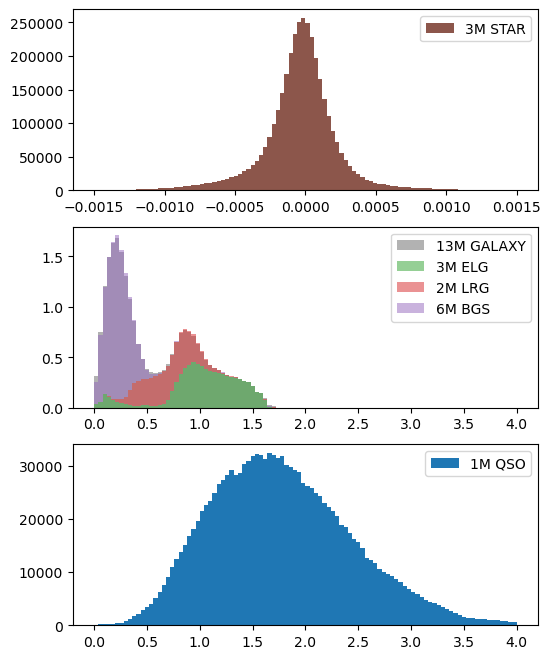

In [61]:
#colors = {'STAR': 'black', 'BGS': 'darkgrey', 'LRG': 'red', 'ELG': 'deepskyblue', 'QSO': 'forestgreen'}
colors = {'STAR': 'C5', 'BGS': 'C4', 'LRG': 'C3', 'ELG': 'C2', 'QSO': 'C0'}
    
stellar_lims = [-0.0015, 0.0015]
extragal_lims = [0, 4.0]
nbins = 100    

zcat = zcat_bysurvey_iron['main']

fig, ax = plt.subplots(3, 1, figsize=(6, 8))
for ispec, spectype in enumerate(['STAR', 'GALAXY', 'QSO']):
    if spectype == 'STAR':
        lims =  stellar_lims
    else:
        lims = extragal_lims

    spectype_selection = zcat['SPECTYPE'] == spectype
    #n_all, bins_all = np.histogram(zcat['Z'][spectype_selection], bins=nbins, range=lims)
        
    if spectype == 'GALAXY':
        
        #ax[ispec].bar(bins_all[:-1], n_all, #histtype='barstacked',
        #              color='gray', alpha=0.6, 
        #              label=f'{get_N_summary_str(np.sum(spectype_selection))} {spectype}')
        
        zs, labels, colorlist = list(), list(), list()
        for itrace, tracer in enumerate(['BGS', 'LRG', 'ELG'][::-1]):
            colname = f"IS{tracer}"
            #label = f'{get_N_summary_str(np.sum(zcat[colname]))} {tracer}'
            labels.append(f'{get_N_summary_str(np.sum(zcat[colname]))} {tracer}')
            colorlist.append(colors[tracer])
            if tracer == 'BGS':
                #zs = zcat['Z'][((zcat[colname]) & (~zcat['ISLRG']))]
                zs.append(zcat['Z'][((zcat[colname]) & (~zcat['ISLRG']))])
            elif tracer == 'LRG':
                #zs = zcat['Z'][((zcat[colname]) & (~zcat['ISELG']))]
                zs.append(zcat['Z'][((zcat[colname]) & (~zcat['ISELG']))])
            else:
                #zs = zcat['Z'][zcat[colname]]
                zs.append(zcat['Z'][zcat[colname]])
                
            #n_one, bins_one = np.histogram(zs, bins=nbins, range=lims)
            #ax[ispec].bar(bins_one[:-1], n_one, #histtype='barstacked',
            #               color=colors[tracer], alpha=0.5)#, label=labels)
        
        _ = ax[ispec].hist(zcat['Z'][spectype_selection], bins=nbins, range=lims, density=True,
                           color='gray', alpha=0.6, label=f'{get_N_summary_str(np.sum(spectype_selection))} {spectype}')
        _ = ax[ispec].hist(zs, bins=nbins, range=lims, color=colorlist, alpha=0.5, 
                           label=labels, stacked=True, histtype='barstacked', density=True)
    else:
        tracer = spectype
        colname = f"IS{tracer}"     
        #n = ax[ispec].hist(zcat['Z'][spectype_selection], bins=nbins, range=lims, color='gray', 
        #                   alpha=0.6, label=f'{get_N_summary_str(np.sum(spectype_selection))} {spectype}*')[0]
        n = ax[ispec].hist(zcat['Z'][zcat[colname]], bins=nbins, range=lims, color=colors[tracer],
                           label=f'{get_N_summary_str(np.sum(zcat[colname]))} {tracer}')[0]    
    ax[ispec].legend()

In [40]:
def generate_Nofz(zcat_bysurvey, save_figures=False):

    colors = {'STAR':'C5', 'BGS':'C4', 'LRG':'C3', 'ELG':'C2', 'QSO':'C0'}
    stellar_lims = [-0.0015, 0.0015]
    extragal_lims = [0, 4.0]
    nbins = 40    

    for survey in zcat_bysurvey.keys():
        zcat = zcat_bysurvey[survey]
        plt.figure(figsize=(8, 8), dpi=120)
        plt.subplot(511)

        if survey == 'Total':
            title_survey = 'Early Data Release'
        else:
            title_survey = f'EDR: {survey} Survey'

        plt.title(f'{title_survey} N(z)')

        print(f"For {survey}:\n")
        for i, tracer in enumerate(['STAR', 'BGS', 'LRG', 'ELG', 'QSO']):
            plt.subplot(511+i)
            colname = f"IS{tracer}"
            
            if tracer == 'STAR':
                lims =  stellar_lims
            else:
                lims = extragal_lims

            n = plt.hist(subset['Z'][subset[colname]], bins=nbins, range=lims, color=colors[tracer])[0]
            plt.ylabel(latex_N_subscript(tracer))
        
            plt.text(lims[1]*1.03, int(0.8*np.max(n)), f'{get_N_summary_str(np.sum(subset[colname]))} {tracer}', ha='right')

        plt.xlabel('redshift')

        plt.tight_layout()
        if save_figures:
            plt.savefig(f'./figures/dr1_{survey.lower()}_Nz.png', facecolor='white', dpi=200)
        plt.show()
        print("\n\n")

        plt.close()

In [42]:
zcat_bysurvey_guadalupe.keys()

dict_keys(['special', 'main'])

In [41]:
generate_Nofz(zcat_bysurvey_guadalupe)

ValueError: too many values to unpack (expected 2)

In [ ]:
stop

#### Choose 4 random extragalactic objects from Iron/main.

In [18]:
if False:
    nshow = 4
    print(f"{nshow} examples of extragalactic targets:")
    exgal = np.where(zcat_main['ISEXG'])[0]
    I = rand.integers(0, len(exgal), nshow)
    zcat_main[exgal][I]

    print("Four examples of spectra where targeting + Redrock did not agree on the type / class.")
    nocat = np.where(~zcat_main['GOODTYPE'])[0]
    I = rand.integers(0, len(nocat), nshow)

    for targetid, spectype in zip(zcat_main[nocat][I]['TARGETID'], zcat_main[nocat][I]['SPECTYPE']):
        print(f'{targetid}: spectype={spectype}, targeting_bits={get_targeting_bits(targetid)}')
    
    zcat_main[nocat][I]

#### For each survey, plot the stacked N(z) distribution for the DESI main extragalactic tracer classes

In [ ]:
for survey, subset in subsets.items():
    plt.figure(figsize=(6,4), dpi=120)

    if survey == 'Total':
        title_survey = 'Early Data Release'
    else:
        title_survey = f'EDR: {survey} Survey'

    plt.title(f'{title_survey} Stacked N(z)')

    print(f"For {survey}:\n")
    zs, labels, colorlist = list(), list(), list()
    for i, tracer in enumerate(['BGS', 'LRG', 'ELG', 'QSO'][::-1]):
        colname = f"IS{tracer}"
        zs.append(subset['Z'][subset[colname]])
        labels.append(f'{get_N_summary_str(np.sum(subset[colname]))} {tracer}')
        colorlist.append(colors[tracer])
        
    lims = extragal_lims
    n = plt.hist(zs, bins=nbins, range=lims, 
                 color=colorlist, alpha=0.5, label=labels, stacked=True, histtype='barstacked')[0]
    plt.ylabel('Number of Objects')
        
    plt.legend()
    plt.xlabel('redshift')

    plt.tight_layout()
    if save_figures:
        plt.savefig(f'./generated_figures/edr_stacked_{survey.lower()}_Nz.png', facecolor='white', dpi=200)
    plt.show()
    print("\n\n")
    plt.close()

#### For each survey, plot the *stacked* N(z) distribution for the Redrock SPECTYPE classes

In [ ]:
for survey, subset in subsets.items():
    plt.figure(figsize=(7.5,5.5), dpi=120)
    plt.subplot(311)

    if survey == 'Total':
        title_survey = 'Early Data Release'
    else:
        title_survey = f'EDR: {survey} Survey'

    plt.title(f'{title_survey} Stacked N(z)')

    print(f"For {survey}:\n")
    
    for i, spectype in enumerate(['STAR', 'GALAXY', 'QSO']):
        plt.subplot(311+i)
            
        if spectype == 'STAR':
            lims =  stellar_lims
        else:
            lims = extragal_lims

        if spectype == 'GALAXY':
            zs, labels, colorlist = list(), list(), list()
            for i, tracer in enumerate(['BGS', 'LRG', 'ELG'][::-1]):
                colname = f"IS{tracer}"
                if tracer == 'BGS':
                    zs.append(subset['Z'][((subset[colname])&(~subset['ISLRG']))])
                elif tracer == 'LRG':
                    zs.append(subset['Z'][((subset[colname])&(~subset['ISELG']))])    
                else:
                    zs.append(subset['Z'][subset[colname]])
                labels.append(f'{get_N_summary_str(np.sum(subset[colname]))} {tracer}')
                colorlist.append(colors[tracer])
            spectype_selection = (subset['SPECTYPE']==spectype)
            n = plt.hist(subset['Z'][spectype_selection], bins=nbins, range=lims, 
                         color='gray', alpha=0.6, label=f'{get_N_summary_str(np.sum(spectype_selection))} {spectype}')[0]
            n = plt.hist(zs, bins=nbins, range=lims, color=colorlist, alpha=0.5, 
                         label=labels, stacked=True, histtype='barstacked')[0]
        else:
            tracer = spectype
            colname = f"IS{tracer}"     
            spectype_selection = (subset['SPECTYPE']==spectype)
            n = plt.hist(subset['Z'][spectype_selection], bins=nbins, range=lims, color='gray', 
                         alpha=0.6, label=f'{get_N_summary_str(np.sum(spectype_selection))} {spectype}*')[0]
            n = plt.hist(subset['Z'][subset[colname]], bins=nbins, range=lims, color=colors[tracer],
                         label=f'{get_N_summary_str(np.sum(subset[colname]))} {tracer}')[0]

        plt.ylabel(latex_N_subscript(spectype))
        plt.legend()

    plt.xlabel('redshift')

    plt.tight_layout()
    if save_figures:
        plt.savefig(f'./generated_figures/edr_stacked_{survey.lower()}_Nz_withallspectype.png', facecolor='white', dpi=200)
    plt.show()
    print("\n\n")

    plt.close()


#### For each survey, plot the N(z) distribution for the Redrock SPECTYPE classes

In [ ]:
#linestyles = {'BGS': 'solid', 'LRG': 'dashed', 'ELG': 'dotted'}
hatches = {'BGS': '/', 'LRG': r'', 'ELG': "\\"}
import matplotlib
matplotlib.rcParams.update({'font.size': 12.6})

for survey, subset in subsets.items():
    # plt.figure(figsize=(7.5,5.5), dpi=120)
    plt.figure(figsize=(7.5,5.5), dpi=120)

    plot1 = plt.subplot2grid((8, 1), (0, 0), rowspan=2)
    plot2 = plt.subplot2grid((8, 1), (2, 0), rowspan=4)
    plot3 = plt.subplot2grid((8, 1), (6, 0), rowspan=2)

    if survey == 'Total':
        title_survey = 'DESI Early Data Release'
        # zenodo[spectype] = Table with N(z) for that spectype
        # different spectypes get different tables because of different N(z) binning
        zenodo = dict()
    else:
        title_survey = f'DESI EDR: {survey} Survey'

    plot1.set_title(f'{title_survey} N(z)')
    
    print(f"For {survey}:\n")
    
    
    for plot, spectype in zip([plot1, plot2, plot3],
                              ['STAR', 'GALAXY', 'QSO']):
        if spectype == 'STAR':
            lims =  stellar_lims
        else:
            lims = extragal_lims
            
        if survey == 'Total':
            zenodo[spectype] = Table()

        if spectype == 'GALAXY':
            spectype_selection = (subset['SPECTYPE']==spectype)
            n, binedges = plot.hist(subset['Z'][spectype_selection], bins=nbins, range=lims, color='gray', 
                         alpha=0.4, label=f'{get_N_summary_str(np.sum(spectype_selection))} {spectype}*')[0:2]
            
            bincenters = (binedges[0:-1] + binedges[1:])/2
            if survey == 'Total':
                zenodo[spectype]['Z'] = bincenters
                zenodo[spectype]['ALL'] = n
            
            for i, tracer in enumerate(['BGS', 'LRG', 'ELG'][::-1]):
                colname = f"IS{tracer}"
                if tracer == 'BGS':
                    zs = subset['Z'][((subset[colname])&(~subset['ISLRG']))]
                elif tracer == 'LRG':
                    zs = subset['Z'][((subset[colname])&(~subset['ISELG']))] 
                else:
                    zs= subset['Z'][subset[colname]]
                n = plot.hist(zs, bins=nbins, range=lims, color=colors[tracer], alpha=0.5, 
                             label=f'{get_N_summary_str(np.sum(subset[colname]))} {tracer}',
                              edgecolor=colors[tracer], linewidth=1.2, histtype='stepfilled',
                              hatch=hatches[tracer])[0]
                
                if survey == 'Total':
                    zenodo[spectype][tracer] = n
        else:
            tracer = spectype
            colname = f"IS{tracer}"     
            spectype_selection = (subset['SPECTYPE']==spectype)
            n, binedges = plot.hist(subset['Z'][spectype_selection], bins=nbins, range=lims, color='gray', 
                         alpha=0.4, label=f'{get_N_summary_str(np.sum(spectype_selection))} {spectype}*')[0:2]
            
            bincenters = (binedges[0:-1] + binedges[1:])/2
            if survey == 'Total':
                zenodo[spectype]['Z'] = bincenters
                zenodo[spectype]['ALL'] = n

            n = plot.hist(subset['Z'][subset[colname]], bins=nbins, range=lims, color=colors[tracer], 
                         label=f'{get_N_summary_str(np.sum(subset[colname]))} {tracer}',
                         edgecolor=colors[tracer], linewidth=1.2)[0]

            if survey == 'Total':
                zenodo[spectype][spectype] = n
            
        plot.set_ylabel(latex_N_subscript(spectype))
        plot.legend()

    plot.set_xlabel('redshift')

    plt.tight_layout()
    if save_figures:
        # plt.savefig(f'./generated_figures/edr_{survey.lower()}_Nz_withallspectype-1-2-1.png', facecolor='white', dpi=200)
        plt.savefig(f'./generated_figures/edr_{survey.lower()}_Nz_withallspectype-1-2-1.pdf', facecolor='white')
    plt.show()
    print("\n\n")

    plt.close()


#### Write data files for Zenodo, one per SPECTYPE

In [ ]:
if save_figures:
    for spectype in zenodo:
        outfile = f'Nz_{spectype}.csv'
        zenodo[spectype].write(outfile, overwrite=True)
        print(f'Wrote {outfile}')